In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

Import Modules

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-06-28 12:39:35.538116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 12:39:35.538245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 12:39:35.719110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BaseDir = "/kaggle/input/flickr8k"
WorkDir = "/kaggle/working"

**Extracting Image features**

In [7]:
##load the model
model = VGG16()
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)
## we are using tranfer learning so we donot need the final predictions layer of the model
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
##extracting features
features = {}
directory = os.path.join(BaseDir,'Images')

for img_name in tqdm(os.listdir(directory)):
    ##load image from directory
    img_path = directory + '/' + img_name
    image = load_img(img_path , target_size = (224,224))
    ##convert image to array
    image = img_to_array(image)
    ##reshape input for the model
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    ##preprocess image
    image = preprocess_input(image)
    ##extract features
    feature = model.predict(image , verbose = 0)
    ##get image id
    image_id = img_name.split('.')[0]
    ##store
    features[image_id] = feature
    

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1719580397.026110     609 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
##saving the features
pickle.dump(features,open(os.path.join(WorkDir,'features.pkl'),"wb"))

In [14]:
##reloading the features
with open(os.path.join(WorkDir,'features.pkl'),"rb") as f:
    features = pickle.load(f)

load captions

In [18]:
with open(os.path.join(BaseDir,'captions.txt'),"r") as f:
    next(f)
    captions_doc = f.read()

In [21]:
##a mapping of images to caption
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma
    token = line.split(',')
    if(len(line)<2):
        continue
    ## get image id and caption list
    image_id , caption = token[0],token[1:]
    ##remve the extension
    image_id = image_id.split('.')[0]
    ##list of caption to string
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [22]:
len(mapping)

8091

In [26]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i];
            ## lower case all the words
            caption = caption.lower()
            ##delete characers other than the alphabets
            caption = caption.replace('[^A-Za-z]', '')
            ##dlete extra spaces
            caption = caption.replace('\s+',' ')
            ## add start and endsequence
            caption = 'start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' end'
            captions[i] = caption
    

In [27]:
##before preprocess
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [28]:
clean(mapping)

In [29]:
## after preprocess
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [30]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [31]:
len(all_captions)

40455

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size  = len(tokenizer.word_index) + 1
print(vocab_size)

8483


In [64]:
max_length = max(len(caption.split())for caption in all_captions)
max_length

35

In [40]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.9)
train = image_ids[:split]
test = image_ids[:split]

In [61]:
# ##data generator funtion to avoid session crashing
# def data_generator(data_keys,mapping, features , tokenizer, max_length,vocab_size,batch_size):
#     x1 , x2 , y = list() , list() ,list()
#     n = 0
#     while 1:
#         for key in data_keys:
#             n+=1
#             captions = mapping[key]
#             for caption in captions:
#                 seq = tokenizer.texts_to_sequences([caption])[0]
#                 for i in range(1,len(seq)):
#                     in_seq, out_seq = seq[:i] , seq[i]
#                     in_seq = pad_sequences([in_seq] , maxlen = max_length)[0]
#                     out_seq = to_categorical([out_seq] , num_classes = vocab_size)[0]
#                     x1.append(features[key][0])
#                     x2.append(in_seq)
#                     y.append(out_seq)
#                 if n == batch_size:
#                     x1 , x2 ,y = np.array(x1), np.array(x2), np.array(y)
#                     yield [x1,x2] ,y
#                     x1,x2,y = list() , list() ,list()
#                     n = 0

In [81]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

model building

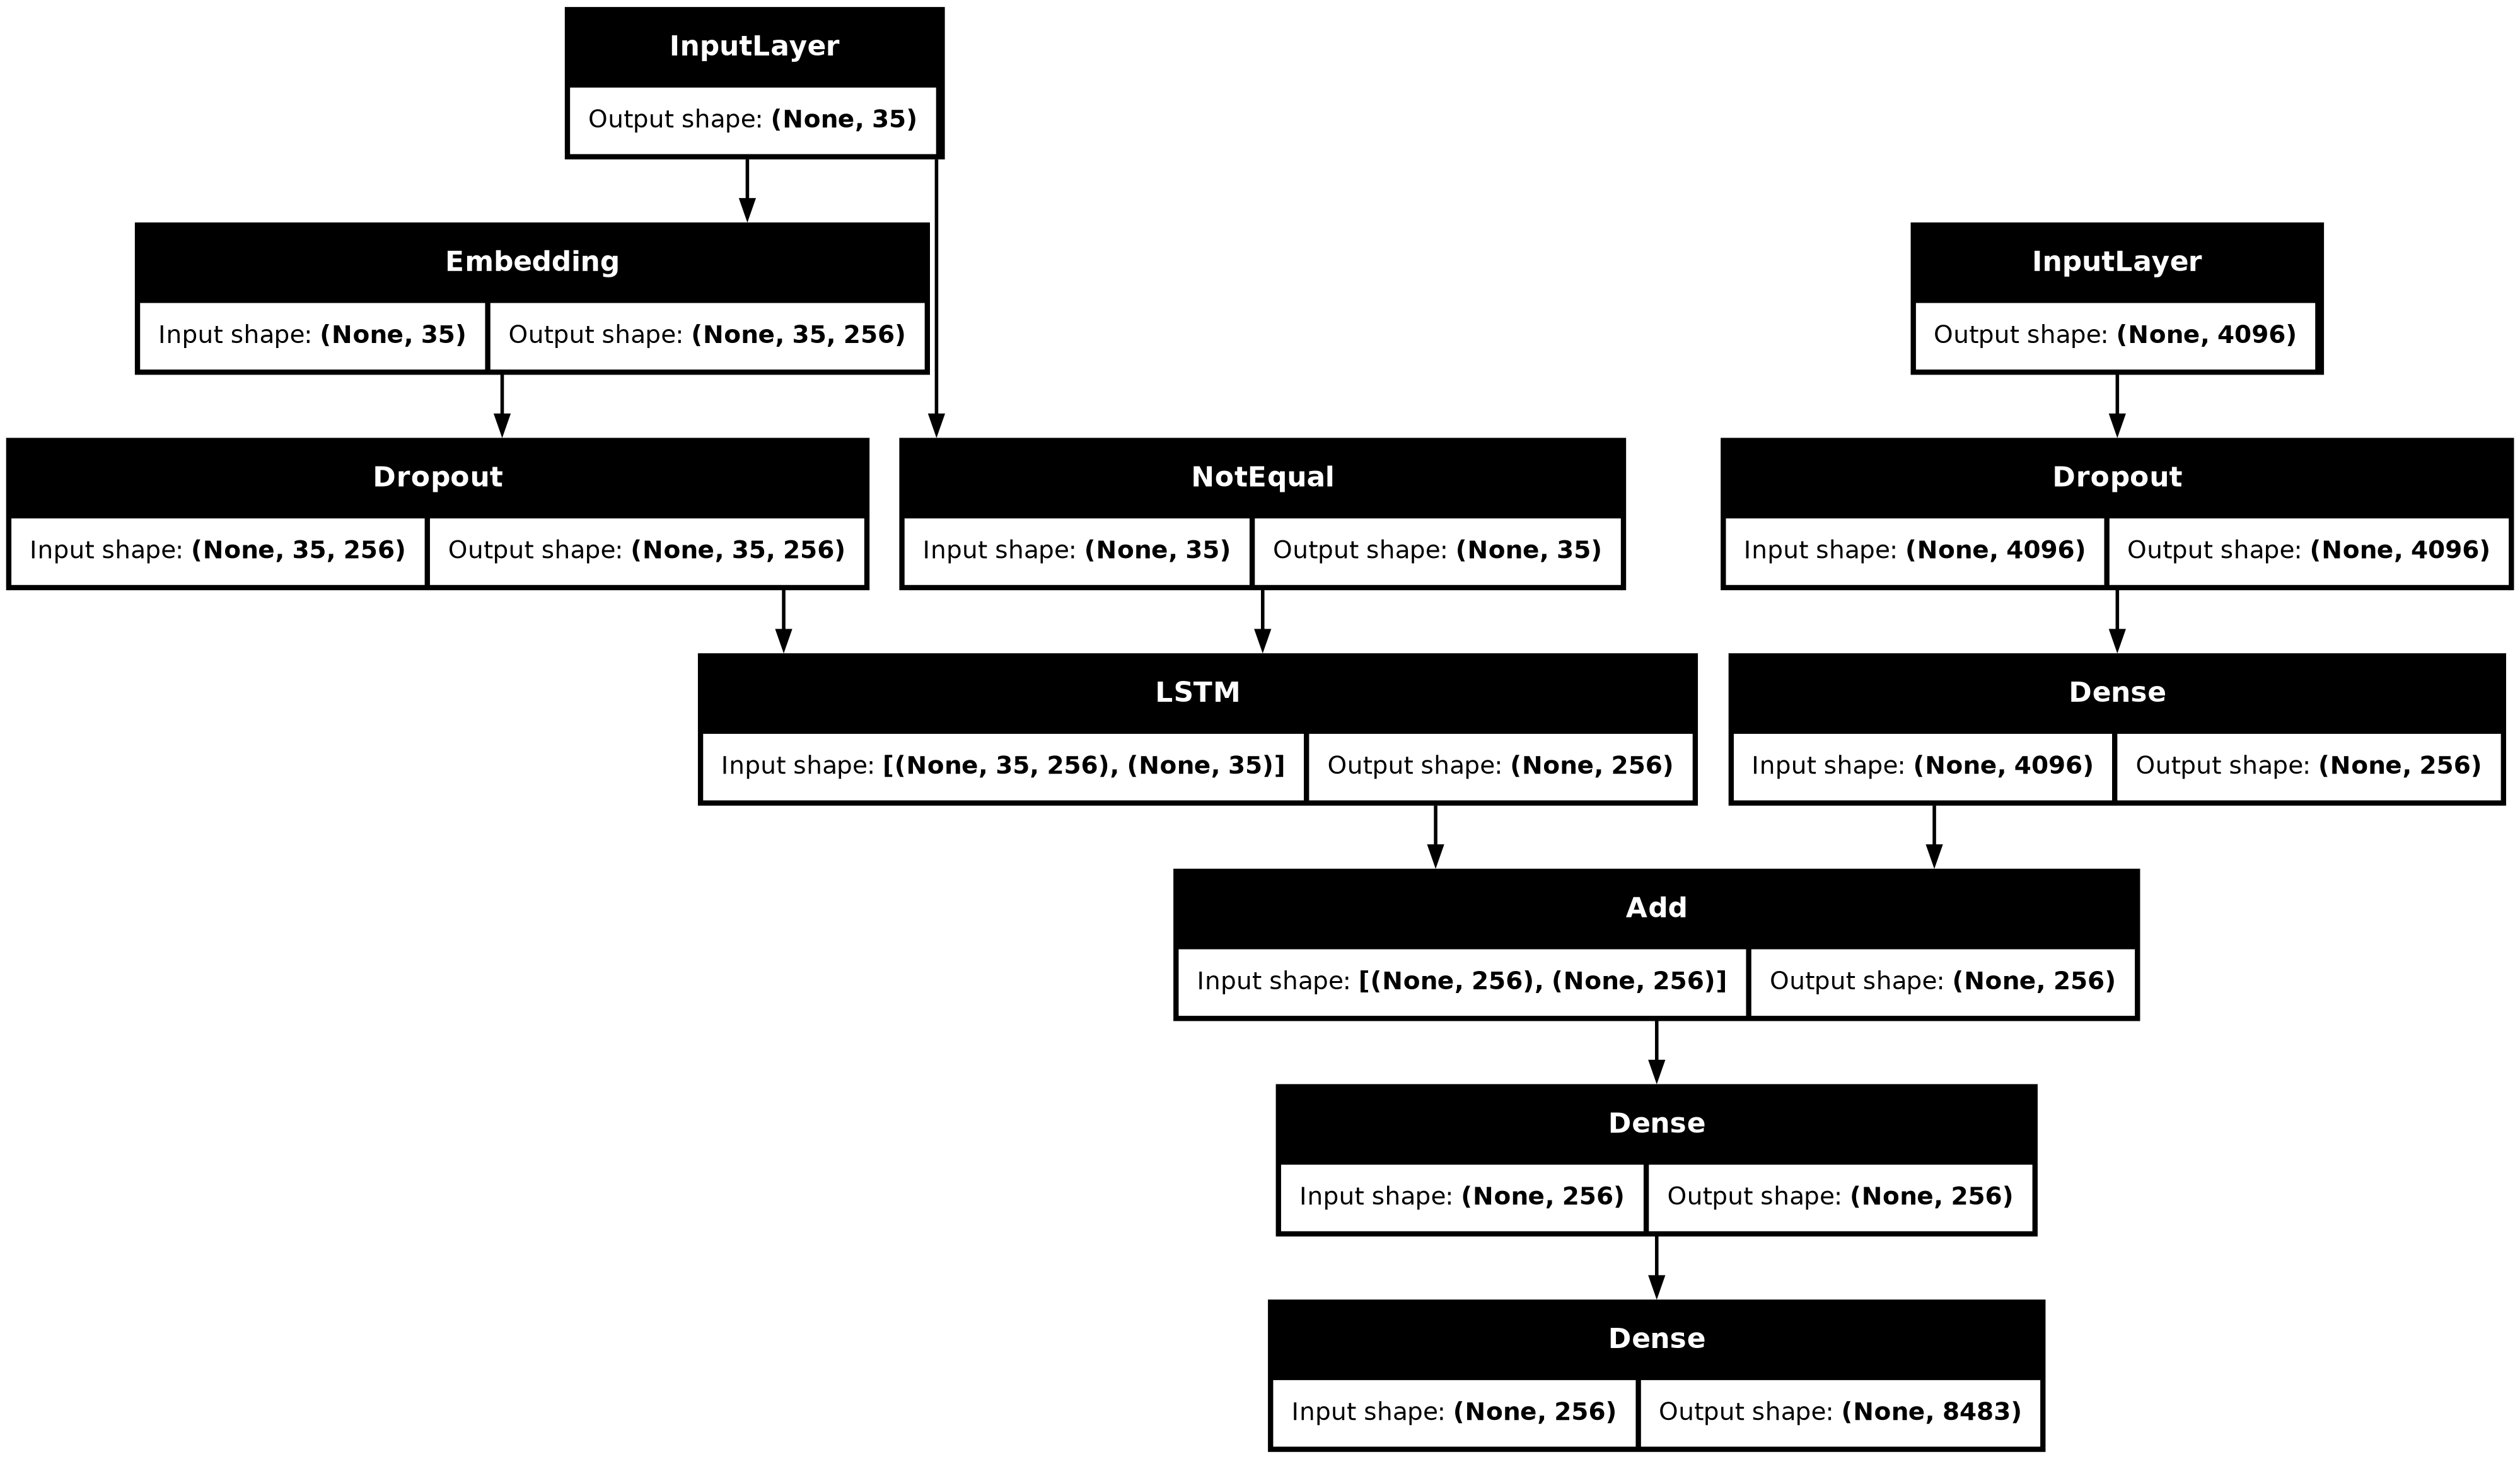

In [84]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256,use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

data_keys,mapping, features , tokenizer, max_length,vocab_size,batch_size

In [85]:
# train the model
epochs = 25
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  1/227 ━━━━━━━━━━━━━━━━━━━━ 27:21 7s/step - loss: 9.0648

W0000 00:00:1719592492.793797     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592492.850029     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592492.913445     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/227 ━━━━━━━━━━━━━━━━━━━━ 17:21 5s/step - loss: 8.9596

W0000 00:00:1719592497.420637     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592497.423889     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592497.477739     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592497.541499     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/227 ━━━━━━━━━━━━━━━━━━━━ 17:20 5s/step - loss: 8.8069

W0000 00:00:1719592502.091677     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592502.141312     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592502.203885     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/227 ━━━━━━━━━━━━━━━━━━━━ 17:12 5s/step - loss: 8.6127

W0000 00:00:1719592506.677841     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592506.680891     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592506.735168     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592506.798058     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/227 ━━━━━━━━━━━━━━━━━━━━ 17:17 5s/step - loss: 8.4670

W0000 00:00:1719592511.490554     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592511.493803     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592511.547979     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592511.611482     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/227 ━━━━━━━━━━━━━━━━━━━━ 14:24 4s/step - loss: 8.2009

W0000 00:00:1719592516.361527     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592516.418310     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592516.482709     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/227 ━━━━━━━━━━━━━━━━━━━━ 14:46 4s/step - loss: 8.0846

W0000 00:00:1719592521.122511     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592521.125864     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592521.179826     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592521.242866     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/227 ━━━━━━━━━━━━━━━━━━━━ 15:02 4s/step - loss: 7.9825

W0000 00:00:1719592525.928720     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592525.985018     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592526.047496     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/227 ━━━━━━━━━━━━━━━━━━━━ 15:11 4s/step - loss: 7.8923

W0000 00:00:1719592530.593832     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592530.650714     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592530.722250     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/227 ━━━━━━━━━━━━━━━━━━━━ 15:15 4s/step - loss: 7.8111

W0000 00:00:1719592535.177989     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592535.180929     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592535.234355     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592535.297426     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/227 ━━━━━━━━━━━━━━━━━━━━ 15:20 4s/step - loss: 7.7383

W0000 00:00:1719592539.862976     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592539.866196     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592539.920906     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592539.985774     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 13/227 ━━━━━━━━━━━━━━━━━━━━ 15:23 4s/step - loss: 7.6729

W0000 00:00:1719592544.571330     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592544.627769     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592544.690488     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/227 ━━━━━━━━━━━━━━━━━━━━ 15:24 4s/step - loss: 7.6137

W0000 00:00:1719592549.246450     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592549.302186     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592549.366088     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/227 ━━━━━━━━━━━━━━━━━━━━ 15:26 4s/step - loss: 7.5589

W0000 00:00:1719592553.983075     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592554.033019     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592554.091288     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/227 ━━━━━━━━━━━━━━━━━━━━ 15:26 4s/step - loss: 7.5092

W0000 00:00:1719592558.628618     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592558.631538     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592558.684556     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592558.745323     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/227 ━━━━━━━━━━━━━━━━━━━━ 15:25 4s/step - loss: 7.4629

W0000 00:00:1719592563.293061     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592563.296138     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592563.349393     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592563.412412     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/227 ━━━━━━━━━━━━━━━━━━━━ 15:24 4s/step - loss: 7.4188

W0000 00:00:1719592568.020101     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592568.023429     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592568.076484     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592568.138763     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/227 ━━━━━━━━━━━━━━━━━━━━ 15:26 4s/step - loss: 7.3777

W0000 00:00:1719592572.932826     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592572.988657     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592573.053091     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/227 ━━━━━━━━━━━━━━━━━━━━ 15:26 4s/step - loss: 7.3393

W0000 00:00:1719592577.816049     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592577.865802     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592577.931002     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/227 ━━━━━━━━━━━━━━━━━━━━ 15:26 4s/step - loss: 7.3029

W0000 00:00:1719592582.727041     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592582.781852     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592582.842458     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/227 ━━━━━━━━━━━━━━━━━━━━ 15:26 5s/step - loss: 7.2681

W0000 00:00:1719592587.685617     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592587.734489     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592587.792909     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/227 ━━━━━━━━━━━━━━━━━━━━ 15:24 5s/step - loss: 7.2352

W0000 00:00:1719592592.549073     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592592.604977     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592592.668576     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/227 ━━━━━━━━━━━━━━━━━━━━ 15:23 5s/step - loss: 7.2041

W0000 00:00:1719592597.438261     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592597.494921     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592597.560766     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/227 ━━━━━━━━━━━━━━━━━━━━ 15:21 5s/step - loss: 7.1744

W0000 00:00:1719592602.315537     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592602.369805     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592602.437589     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/227 ━━━━━━━━━━━━━━━━━━━━ 15:19 5s/step - loss: 7.1464

W0000 00:00:1719592607.109490     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592607.112602     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592607.165868     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592607.229051     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/227 ━━━━━━━━━━━━━━━━━━━━ 15:16 5s/step - loss: 7.1200

W0000 00:00:1719592611.944720     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592612.000566     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592612.065158     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/227 ━━━━━━━━━━━━━━━━━━━━ 15:13 5s/step - loss: 7.0946

W0000 00:00:1719592616.695808     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592616.750400     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592616.812500     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/227 ━━━━━━━━━━━━━━━━━━━━ 14:03 4s/step - loss: 7.0246

W0000 00:00:1719592621.875564     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592621.931390     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592621.993000     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/227 ━━━━━━━━━━━━━━━━━━━━ 14:02 4s/step - loss: 7.0030

W0000 00:00:1719592626.654811     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592626.709464     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592626.771514     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/227 ━━━━━━━━━━━━━━━━━━━━ 14:00 4s/step - loss: 6.9821

W0000 00:00:1719592631.444994     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592631.495034     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592631.554812     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/227 ━━━━━━━━━━━━━━━━━━━━ 13:30 4s/step - loss: 6.9424

W0000 00:00:1719592636.271699     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592636.274780     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592636.329401     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592636.394198     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/227 ━━━━━━━━━━━━━━━━━━━━ 13:29 4s/step - loss: 6.9235

W0000 00:00:1719592641.032967     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592641.089028     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592641.159485     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/227 ━━━━━━━━━━━━━━━━━━━━ 13:27 4s/step - loss: 6.9051

W0000 00:00:1719592645.846089     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592645.900690     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592645.962355     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/227 ━━━━━━━━━━━━━━━━━━━━ 13:26 4s/step - loss: 6.8874

W0000 00:00:1719592650.697819     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592650.753032     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592650.816912     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/227 ━━━━━━━━━━━━━━━━━━━━ 13:25 4s/step - loss: 6.8702

W0000 00:00:1719592655.502658     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592655.557779     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592655.626694     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/227 ━━━━━━━━━━━━━━━━━━━━ 13:23 4s/step - loss: 6.8534

W0000 00:00:1719592660.287750     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592660.343570     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592660.407684     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/227 ━━━━━━━━━━━━━━━━━━━━ 13:21 4s/step - loss: 6.8372

W0000 00:00:1719592665.132513     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592665.188459     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592665.259215     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/227 ━━━━━━━━━━━━━━━━━━━━ 13:19 4s/step - loss: 6.8215

W0000 00:00:1719592670.025482     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592670.080285     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592670.142553     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/227 ━━━━━━━━━━━━━━━━━━━━ 13:17 4s/step - loss: 6.8062

W0000 00:00:1719592674.796014     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592674.846117     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592674.906036     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/227 ━━━━━━━━━━━━━━━━━━━━ 12:53 4s/step - loss: 6.7767

W0000 00:00:1719592679.713593     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592679.763262     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592679.821532     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/227 ━━━━━━━━━━━━━━━━━━━━ 12:51 4s/step - loss: 6.7624

W0000 00:00:1719592684.563615     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592684.613204     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592684.670912     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/227 ━━━━━━━━━━━━━━━━━━━━ 12:48 4s/step - loss: 6.7483

W0000 00:00:1719592689.236224     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592689.285941     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592689.352357     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/227 ━━━━━━━━━━━━━━━━━━━━ 12:46 4s/step - loss: 6.7344

W0000 00:00:1719592693.930965     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592693.985850     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592694.048488     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/227 ━━━━━━━━━━━━━━━━━━━━ 12:43 4s/step - loss: 6.7208

W0000 00:00:1719592698.779625     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592698.828195     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592698.885744     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/227 ━━━━━━━━━━━━━━━━━━━━ 12:22 4s/step - loss: 6.6946

W0000 00:00:1719592703.706180     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592703.761000     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592703.824721     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/227 ━━━━━━━━━━━━━━━━━━━━ 12:19 4s/step - loss: 6.6820

W0000 00:00:1719592708.420734     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592708.423925     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592708.477673     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592708.538346     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/227 ━━━━━━━━━━━━━━━━━━━━ 12:17 4s/step - loss: 6.6695

W0000 00:00:1719592713.152902     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592713.208973     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592713.273899     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/227 ━━━━━━━━━━━━━━━━━━━━ 12:14 4s/step - loss: 6.6574

W0000 00:00:1719592717.901825     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592717.957849     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592718.021143     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/227 ━━━━━━━━━━━━━━━━━━━━ 12:12 4s/step - loss: 6.6455

W0000 00:00:1719592722.622334     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592722.672253     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592722.731755     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/227 ━━━━━━━━━━━━━━━━━━━━ 12:09 4s/step - loss: 6.6341

W0000 00:00:1719592727.480729     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592727.539047     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592727.604198     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/227 ━━━━━━━━━━━━━━━━━━━━ 12:07 4s/step - loss: 6.6230

W0000 00:00:1719592732.523625     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592732.579741     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592732.641956     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/227 ━━━━━━━━━━━━━━━━━━━━ 12:05 4s/step - loss: 6.6122

W0000 00:00:1719592737.417381     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592737.472291     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592737.534462     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/227 ━━━━━━━━━━━━━━━━━━━━ 11:46 4s/step - loss: 6.5909

W0000 00:00:1719592742.250218     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592742.304596     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592742.367547     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/227 ━━━━━━━━━━━━━━━━━━━━ 11:43 4s/step - loss: 6.5806

W0000 00:00:1719592746.897422     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592746.953635     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592747.019344     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/227 ━━━━━━━━━━━━━━━━━━━━ 11:25 4s/step - loss: 6.5605

W0000 00:00:1719592751.773653     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592751.822854     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592751.881637     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/227 ━━━━━━━━━━━━━━━━━━━━ 10:53 4s/step - loss: 6.5315

W0000 00:00:1719592756.738774     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592756.794008     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592756.857645     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/227 ━━━━━━━━━━━━━━━━━━━━ 10:51 4s/step - loss: 6.5221

W0000 00:00:1719592761.491724     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592761.547560     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592761.610412     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/227 ━━━━━━━━━━━━━━━━━━━━ 10:35 4s/step - loss: 6.5039

W0000 00:00:1719592766.489302     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592766.544805     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592766.608858     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/227 ━━━━━━━━━━━━━━━━━━━━ 10:34 4s/step - loss: 6.4950

W0000 00:00:1719592771.446992     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592771.496890     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592771.556565     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/227 ━━━━━━━━━━━━━━━━━━━━ 10:19 4s/step - loss: 6.4775

W0000 00:00:1719592776.442313     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592776.496397     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592776.559105     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/227 ━━━━━━━━━━━━━━━━━━━━ 10:16 4s/step - loss: 6.4689

W0000 00:00:1719592781.054650     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592781.104261     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592781.162752     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/227 ━━━━━━━━━━━━━━━━━━━━ 10:14 4s/step - loss: 6.4604

W0000 00:00:1719592785.781826     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592785.838536     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592785.904475     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/227 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - loss: 6.4520

W0000 00:00:1719592790.563305     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592790.617365     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592790.680751     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/227 ━━━━━━━━━━━━━━━━━━━━ 10:09 4s/step - loss: 6.4437

W0000 00:00:1719592795.524473     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592795.527653     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592795.580554     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592795.643346     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/227 ━━━━━━━━━━━━━━━━━━━━ 9:55 4s/step - loss: 6.4276

W0000 00:00:1719592800.598350     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592800.652547     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592800.715640     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 79/227 ━━━━━━━━━━━━━━━━━━━━ 9:53 4s/step - loss: 6.4196

W0000 00:00:1719592805.342126     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592805.397747     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592805.461793     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/227 ━━━━━━━━━━━━━━━━━━━━ 9:39 4s/step - loss: 6.4041

W0000 00:00:1719592810.337100     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592810.392875     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592810.457126     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/227 ━━━━━━━━━━━━━━━━━━━━ 9:37 4s/step - loss: 6.3966

W0000 00:00:1719592815.175037     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592815.230670     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592815.294852     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/227 ━━━━━━━━━━━━━━━━━━━━ 9:34 4s/step - loss: 6.3891

W0000 00:00:1719592819.736574     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592819.793192     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592819.858920     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/227 ━━━━━━━━━━━━━━━━━━━━ 9:31 4s/step - loss: 6.3818

W0000 00:00:1719592824.457314     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592824.512136     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592824.574378     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/227 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - loss: 6.3673

W0000 00:00:1719592829.174966     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592829.228995     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592829.291684     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/227 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - loss: 6.3602

W0000 00:00:1719592834.017267     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592834.020157     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592834.073776     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592834.137182     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/227 ━━━━━━━━━━━━━━━━━━━━ 9:12 4s/step - loss: 6.3532

W0000 00:00:1719592838.868666     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592838.924994     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592838.989186     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/227 ━━━━━━━━━━━━━━━━━━━━ 9:10 4s/step - loss: 6.3464

W0000 00:00:1719592843.799966     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592843.855097     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592843.917995     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/227 ━━━━━━━━━━━━━━━━━━━━ 9:07 4s/step - loss: 6.3395

W0000 00:00:1719592848.351541     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592848.354748     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592848.408073     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592848.469228     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/227 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - loss: 6.3328

W0000 00:00:1719592853.087535     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592853.142882     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592853.211740     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/227 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - loss: 6.3261

W0000 00:00:1719592857.999460     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592858.049038     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592858.105691     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/227 ━━━━━━━━━━━━━━━━━━━━ 8:58 4s/step - loss: 6.3196

W0000 00:00:1719592862.639240     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592862.689129     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592862.748034     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/227 ━━━━━━━━━━━━━━━━━━━━ 8:55 4s/step - loss: 6.3131

W0000 00:00:1719592867.395972     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592867.400711     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592867.453693     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592867.518435     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 96/227 ━━━━━━━━━━━━━━━━━━━━ 8:43 4s/step - loss: 6.3003

W0000 00:00:1719592872.376911     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592872.426633     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592872.485748     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/227 ━━━━━━━━━━━━━━━━━━━━ 8:31 4s/step - loss: 6.2877

W0000 00:00:1719592877.370160     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592877.425366     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592877.488021     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/227 ━━━━━━━━━━━━━━━━━━━━ 8:19 4s/step - loss: 6.2754

W0000 00:00:1719592882.406482     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592882.460368     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592882.528634     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/227 ━━━━━━━━━━━━━━━━━━━━ 8:00 4s/step - loss: 6.2575

W0000 00:00:1719592887.665523     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592887.668644     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592887.721514     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592887.783301     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/227 ━━━━━━━━━━━━━━━━━━━━ 7:57 4s/step - loss: 6.2516

W0000 00:00:1719592892.336813     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592892.391220     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592892.451261     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/227 ━━━━━━━━━━━━━━━━━━━━ 7:54 4s/step - loss: 6.2458

W0000 00:00:1719592897.267399     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592897.322128     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592897.391248     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/227 ━━━━━━━━━━━━━━━━━━━━ 7:35 4s/step - loss: 6.2288

W0000 00:00:1719592902.450880     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592902.506018     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592902.569646     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/227 ━━━━━━━━━━━━━━━━━━━━ 7:32 4s/step - loss: 6.2233

W0000 00:00:1719592907.276030     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592907.331754     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592907.401592     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/227 ━━━━━━━━━━━━━━━━━━━━ 7:29 4s/step - loss: 6.2177

W0000 00:00:1719592912.008922     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592912.012014     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592912.065013     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592912.125828     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/227 ━━━━━━━━━━━━━━━━━━━━ 7:19 4s/step - loss: 6.2069

W0000 00:00:1719592917.027702     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592917.076999     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592917.133717     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/227 ━━━━━━━━━━━━━━━━━━━━ 7:16 4s/step - loss: 6.2015

W0000 00:00:1719592921.885547     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592921.935420     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592921.994687     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/227 ━━━━━━━━━━━━━━━━━━━━ 7:13 4s/step - loss: 6.1963

W0000 00:00:1719592926.634326     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592926.637523     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592926.690346     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592926.752090     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/227 ━━━━━━━━━━━━━━━━━━━━ 6:56 4s/step - loss: 6.1809

W0000 00:00:1719592931.727568     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592931.781520     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592931.844126     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/227 ━━━━━━━━━━━━━━━━━━━━ 6:25 4s/step - loss: 6.1562

W0000 00:00:1719592937.364943     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592937.368139     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592937.421473     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592937.484768     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/227 ━━━━━━━━━━━━━━━━━━━━ 6:23 4s/step - loss: 6.1514

W0000 00:00:1719592942.124990     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592942.128555     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592942.182732     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592942.243488     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/227 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - loss: 6.1419

W0000 00:00:1719592946.948600     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592947.003287     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592947.064322     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/227 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - loss: 6.1372

W0000 00:00:1719592951.672619     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592951.675850     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592951.728727     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592951.791483     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/227 ━━━━━━━━━━━━━━━━━━━━ 6:01 4s/step - loss: 6.1280

W0000 00:00:1719592956.368639     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592956.423439     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592956.485821     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/227 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - loss: 6.1235

W0000 00:00:1719592961.288183     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592961.338326     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592961.397110     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/227 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - loss: 6.1189

W0000 00:00:1719592966.092812     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592966.142341     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592966.201357     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/227 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - loss: 6.1145

W0000 00:00:1719592970.724671     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592970.727800     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592970.781938     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592970.845353     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/227 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - loss: 6.1100

W0000 00:00:1719592975.383596     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592975.439660     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592975.503314     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/227 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - loss: 6.1056

W0000 00:00:1719592980.080280     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592980.129614     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592980.187017     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/227 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - loss: 6.1012

W0000 00:00:1719592984.742710     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592984.792632     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592984.854766     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/227 ━━━━━━━━━━━━━━━━━━━━ 5:40 4s/step - loss: 6.0968

W0000 00:00:1719592989.403143     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592989.452872     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592989.512302     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/227 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - loss: 6.0925

W0000 00:00:1719592993.979961     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592993.983464     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592994.036531     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592994.099941     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/227 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - loss: 6.0713

W0000 00:00:1719592999.268435     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592999.318301     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719592999.377828     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/227 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - loss: 6.0549

W0000 00:00:1719593004.302641     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593004.357342     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593004.420378     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/227 ━━━━━━━━━━━━━━━━━━━━ 4:32 3s/step - loss: 6.0389

W0000 00:00:1719593009.435831     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593009.492700     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593009.558450     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/227 ━━━━━━━━━━━━━━━━━━━━ 4:29 4s/step - loss: 6.0350

W0000 00:00:1719593014.344423     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593014.347537     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593014.400748     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593014.463756     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/227 ━━━━━━━━━━━━━━━━━━━━ 4:06 3s/step - loss: 6.0156

W0000 00:00:1719593019.476315     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593019.526108     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593019.584850     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/227 ━━━━━━━━━━━━━━━━━━━━ 4:03 3s/step - loss: 6.0118

W0000 00:00:1719593024.050220     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593024.053760     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593024.106873     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593024.167517     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/227 ━━━━━━━━━━━━━━━━━━━━ 4:00 3s/step - loss: 6.0081

W0000 00:00:1719593028.895641     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593028.945205     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593029.003323     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/227 ━━━━━━━━━━━━━━━━━━━━ 3:57 3s/step - loss: 6.0043

W0000 00:00:1719593033.781451     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593033.784749     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593033.838617     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593033.902758     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/227 ━━━━━━━━━━━━━━━━━━━━ 3:49 3s/step - loss: 5.9968

W0000 00:00:1719593038.391312     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593038.446471     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593038.509308     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/227 ━━━━━━━━━━━━━━━━━━━━ 3:47 3s/step - loss: 5.9931

W0000 00:00:1719593043.111465     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593043.166433     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593043.227843     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


166/227 ━━━━━━━━━━━━━━━━━━━━ 3:25 3s/step - loss: 5.9747

W0000 00:00:1719593048.333381     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593048.387354     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593048.449872     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/227 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - loss: 5.9711

W0000 00:00:1719593052.985216     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593053.034948     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593053.093796     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/227 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - loss: 5.9675

W0000 00:00:1719593057.628283     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593057.631447     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593057.684419     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593057.747438     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


174/227 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - loss: 5.9460

W0000 00:00:1719593062.797527     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593062.851902     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593062.913232     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/227 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - loss: 5.9390

W0000 00:00:1719593067.540677     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593067.596363     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593067.660537     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/227 ━━━━━━━━━━━━━━━━━━━━ 2:44 3s/step - loss: 5.9355

W0000 00:00:1719593072.287925     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593072.343411     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593072.406827     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/227 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - loss: 5.9285

W0000 00:00:1719593077.428065     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593077.477352     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593077.535279     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/227 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - loss: 5.9182

W0000 00:00:1719593082.788006     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593082.791687     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593082.845560     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593082.909217     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/227 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - loss: 5.8947

W0000 00:00:1719593088.183203     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593088.237732     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593088.299461     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/227 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - loss: 5.8914

W0000 00:00:1719593092.650950     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593092.700506     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593092.759030     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/227 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - loss: 5.8882

W0000 00:00:1719593097.438631     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593097.495439     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593097.561872     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/227 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - loss: 5.8849

W0000 00:00:1719593102.322544     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593102.378507     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593102.449113     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


194/227 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - loss: 5.8784

W0000 00:00:1719593106.914278     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593106.969717     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593107.032912     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/227 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - loss: 5.8623

W0000 00:00:1719593111.926582     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593111.981438     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593112.045039     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/227 ━━━━━━━━━━━━━━━━━━━━ 1:24 3s/step - loss: 5.8592

W0000 00:00:1719593116.369624     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593116.425608     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593116.490228     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/227 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - loss: 5.8497

W0000 00:00:1719593121.274453     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593121.330208     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593121.394572     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/227 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - loss: 5.8466

W0000 00:00:1719593126.009037     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593126.012265     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593126.066280     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593126.130244     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/227 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - loss: 5.8373

W0000 00:00:1719593131.083122     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593131.132141     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593131.189332     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


208/227 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 5.8342 

W0000 00:00:1719593136.001238     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593136.055332     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593136.118072     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/227 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 5.8190

W0000 00:00:1719593141.212637     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593141.266697     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593141.329322     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/227 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 5.8130

W0000 00:00:1719593146.176219     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593146.232225     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593146.297008     610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/227 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 5.8012

W0000 00:00:1719593151.223408     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593151.279086     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593151.342915     609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 5.7808

W0000 00:00:1719593156.533123     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593156.582064     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719593156.639950     611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - loss: 5.7751
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 4.0550
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 3.5905
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 3.3100
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 3.1063
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 249ms/step - loss: 2.9496
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.8305
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.7373
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 2.6567
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 2.5889
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.5233
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.4667
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 2.4171
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.3709
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.3313
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - loss: 2.2902
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - loss: 2.2562

In [87]:
model.save(WorkDir + '/first_model.h5')

In [103]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [104]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break
      
    return in_text

In [93]:
from nltk.translate.bleu_score import corpus_bleu

In [106]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/7281 [00:00<?, ?it/s]

BLEU-1: 0.647255
BLEU-2: 0.444559


In [107]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BaseDir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)


---------------------Actual---------------------
start black dog and spotted dog are fighting end
start black dog and tri-colored dog playing with each other on the road end
start black dog and white dog with brown spots are staring at each other in the street end
start two dogs of different breeds looking at each other on the road end
start two dogs on pavement moving toward each other end
--------------------Predicted--------------------
start two dogs are playing with puffy white dog on the road end


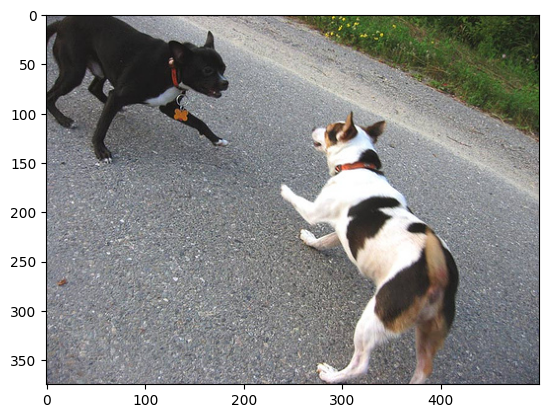

In [108]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
start brown and white dog is running through the snow end
start dog is running in the snow end
start dog running through snow end
start white and brown dog is running through snow covered field end
start the white and brown dog is running over the surface of the snow end
--------------------Predicted--------------------
start white dog with red sled runs on snowy ground end


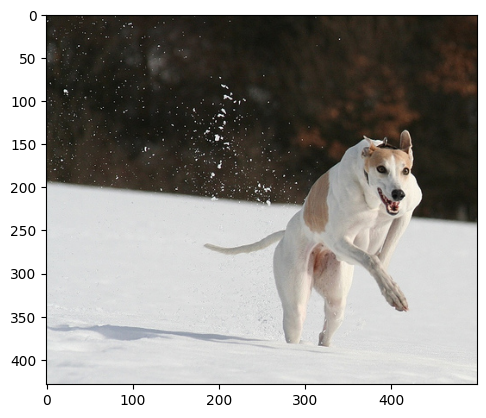

In [109]:
generate_caption("101654506_8eb26cfb60.jpg")

---------------------Actual---------------------
start group of four children wearing pajamas have pillow fight end
start group of kids have pillow-fight end
start group of young children playing pillow fight on bed end
start children having pillow fight end
start four children are having pillow fight end
--------------------Predicted--------------------
start two young boys are playing pillow fight end


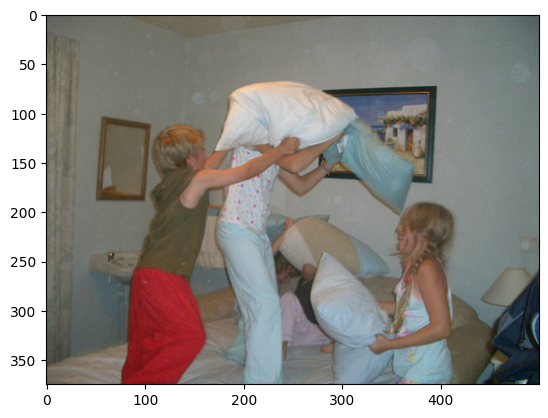

In [112]:
generate_caption("1055623002_8195a43714.jpg")

---------------------Actual---------------------
start girl in pigtails splashes in the shallow water end
start girls plays in the surf end
start girl with pigtails is playing in the ocean by the beach end
start girl with pigtails plays in the water end
start young girl in pigtails plays in the water end
--------------------Predicted--------------------
start girl in pigtails is in the ocean end


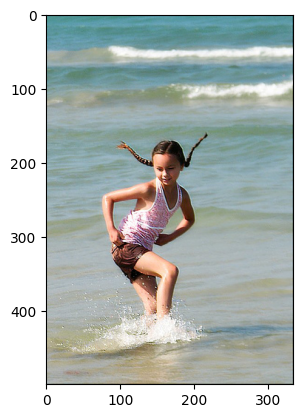

In [113]:
generate_caption("1053804096_ad278b25f1.jpg")

---------------------Actual---------------------
start "one man in red shirt and black pants with man in white shirt and tan shorts golfing ." end
start "tree in the foreground two men playing golf in the background ." end
start two golfers are standing on the fairway looking off into the distance end
start two golfers look off into the distance with hands blocking the sun end
start two men looking into the distance on golf course end
--------------------Predicted--------------------
start the little boy is standing on the grass under the house end


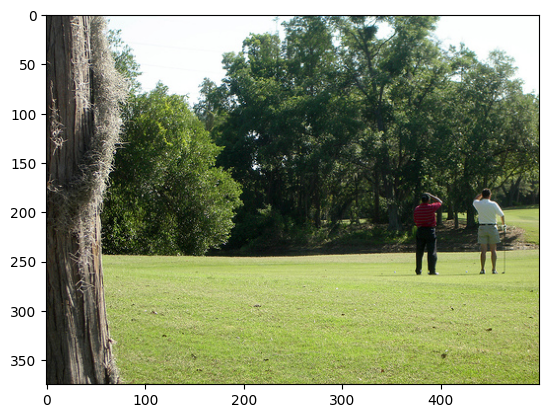

In [116]:
generate_caption("127488876_f2d2a89588.jpg")